In [1]:
%cd /Users/gwg/dmcm

/Users/gwg/dmcm


In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from   PIL import Image
plt.style.use('seaborn-deep')
import seaborn as sns

from   data import GTExConfig, GTExDataset, loader
from   models import DPCCA

In [3]:
%matplotlib inline

In [4]:
cfg = GTExConfig()

# directory = 'experiments/20190131_big_sweep/'\
#             'gtexv8_mode-dpcca_batch_size-128_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.5_em_iters-1_clip-1'

directory = 'experiments/20190305_gtexv6_celeba/'\
            'gtex_mode-dpcca_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.0_em_iters-1'

state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10, use_gene_net=True)
model.load_state_dict(state)

In [5]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    directory=directory)
dataset = train_loader.dataset

In [10]:
inds = train_loader.sampler.indices
# The indices were generated through random shuffling, so this shouldn't bias anything.
inds = inds[:600]
n    = len(inds)
print(n)

# inds = range(0, len(dataset))
# n    = len(inds)

X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2 = torch.Tensor(n, cfg.N_GENES)
labels = torch.Tensor(n)
tissues = []
symbols = []

for j, i in enumerate(inds):
    x1, x2 = dataset[i]
    X1[j] = x1
    X2[j] = x2
    symbols.append(dataset.gene_names[i])
    labels[j] = float(dataset.labels[i])
    tissues.append(dataset.tissues[i])

symbols = np.array(symbols)
tissues = np.array(tissues)

600


In [11]:
Zs = model.estimate_z_given_x([X1, X2], threshold=None)
print(X1.shape)
print(X2.shape)
print(Zs.shape)
Zs = Zs.detach()

torch.Size([600, 3, 128, 128])
torch.Size([600, 18659])
torch.Size([600, 30])


In [12]:
for tiss in np.unique(tissues):
    print(tiss)

Adipose Tissue
Adrenal Gland
Blood Vessel
Brain
Colon
Esophagus
Heart
Kidney
Liver
Lung
Muscle
Ovary
Pancreas
Pituitary
Prostate
Salivary Gland
Small Intestine
Spleen
Stomach
Testis
Thyroid
Uterus
Vagina


In [30]:
def get_images_for_tissue(tiss_name, factor_idx, n_images):
    index = None
    for i in np.unique(labels):
        tiss = dataset.labelEncoder.inverse_transform([int(i)])[0]
        if tiss == tiss_name:
            index = float(i)
            break

    inds = labels.numpy() == index
    images_one_type  = X1.numpy()[inds]
    genes_one_type   = X2.numpy()[inds]
    tissues_one_type = tissues[inds]
    Zs_one_type      = Zs.numpy()[inds]
    
    inds   = np.argsort(Zs_one_type[:, factor_idx])
    images = images_one_type[inds]
    genes  = genes_one_type[inds]
    
    image_chunks = np.array_split(images, n_images)
    gene_chunks  = np.array_split(genes, n_images)
    imgs  = [chunk[0] for chunk in image_chunks]
    genes = [chunk[0] for chunk in gene_chunks] 
    return imgs, genes

def get_top_bot_images(tiss_name, factor_idx, n_images):
    index = None
    for i in np.unique(labels):
        tiss = dataset.labelEncoder.inverse_transform([int(i)])[0]
        if tiss == tiss_name:
            index = float(i)
            break

    inds = labels.numpy() == index
    images_one_type  = X1.numpy()[inds]
    genes_one_type   = X2.numpy()[inds]
    tissues_one_type = tissues[inds]
    Zs_one_type      = Zs.numpy()[inds]
    
    inds   = np.argsort(Zs_one_type[:, factor_idx])
    images = images_one_type[inds]
    genes  = genes_one_type[inds]
    
    half = int(n_images / 2)
    
    images_result = np.concatenate((images[:half, :, :, :], images[-half:, :, :, :]), axis=0)
    genes_result  = np.append(genes[:half], genes[-half:])
    return images_result, genes_result

/Users/gwg/miniconda3/envs/dmcm/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


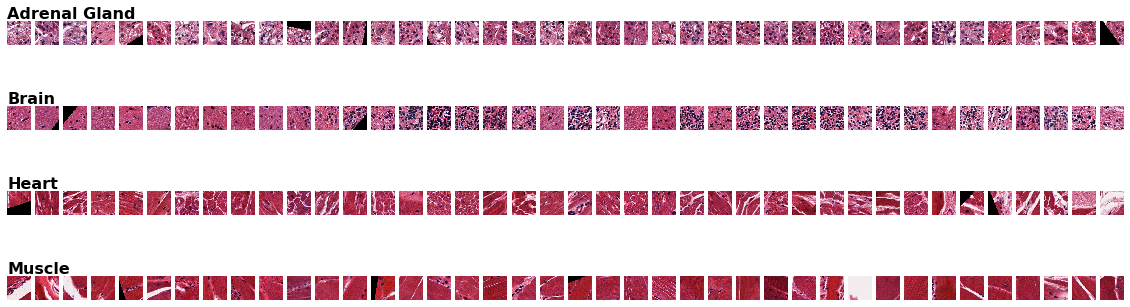

In [17]:
# Adipose Tissue
# Adrenal Gland
# Blood Vessel
# Brain
# Colon
# Esophagus
# Heart
# Kidney
# Liver
# Lung
# Muscle
# Ovary
# Pancreas
# Pituitary
# Prostate
# Salivary Gland
# Small Intestine
# Spleen
# Stomach
# Testis
# Thyroid
# Uterus
# Vagina

data = [
    ('Adrenal Gland', 8),
    ('Brain', 0),
    ('Heart', 13),
    ('Muscle', 0),
]
n_tissues = len(data)
n_images  = 40

fig, axmat = plt.subplots(n_tissues, n_images)

img_axes_rows = []
for i, ax in zip(range(n_tissues), axmat):
    img_axes_rows.append(ax)
    
fig.set_size_inches(20, 1.5 * n_tissues)
plt.axis('off')

for (tiss, idx), axes_row in zip(data, img_axes_rows):
    images, genes = get_images_for_tissue(tiss, idx, n_images)
    axes_row[0].text(0, -15, tiss, fontsize=16, fontweight='bold')
    for img, ax in zip(images, axes_row):
        ax.imshow(img.T)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

plt.tight_layout()

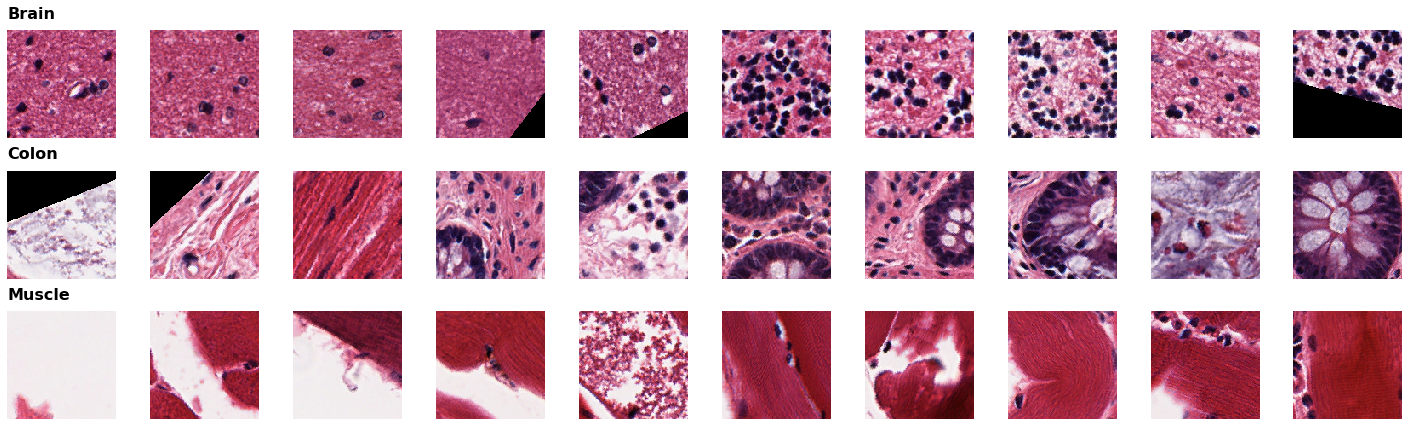

In [128]:
data = [
    ('Brain', 0),
#     ('Adrenal Gland', 8),
    ('Colon', 5), #colon5, #Spleen5 #Heart1
    ('Muscle', 11), # 11
]
n_tissues = len(data)
n_images  = 10

fig, axmat = plt.subplots(n_tissues, n_images)

img_axes_rows = []
for i, ax in zip(range(n_tissues), axmat):
    img_axes_rows.append(ax)
    
fig.set_size_inches(20, 2 * n_tissues)
plt.axis('off')

for (tiss, idx), axes_row in zip(data, img_axes_rows):
    images, _ = get_top_bot_images(tiss, idx, n_images)
    axes_row[0].text(0, -15, tiss, fontsize=16, fontweight='bold')
    for img, ax in zip(images, axes_row):
        ax.imshow(img.T)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

plt.tight_layout()